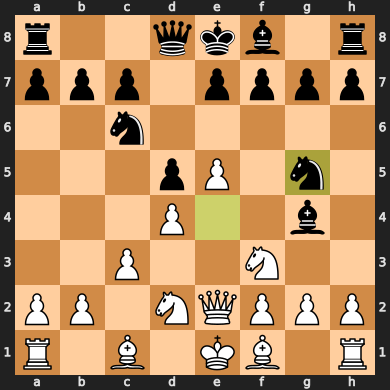

KeyboardInterrupt: Interrupted by user

In [2]:
"""
Anathema
Classical chess engine by Devin Zhang
September 2021 - 
"""


import random
import chess
import chess.engine
import chess.polyglot
import IPython.display


# Options
START_AS = "WHITE" # Human player plays as: WHITE, BLACK, or RANDOM
DEPTH = 3 # Search depth, minimum 1
OPENING = False # Use opening book?


# Constants
INF = float("inf")


# Other
ttable = {} # Transposition table


def get_num_pieces(board, piece, color = "BOTH"):
    """
    Returns the number of a certain piece on the board, given color
    Or returns number of a certain piece of both colors combined
    """
    if color == "BOTH":
        return get_num_pieces(board, piece, chess.WHITE) + get_num_pieces(board, piece, chess.BLACK)
    else:
        return str(board.pieces(piece, color)).count("1")


def evaluate(board):
    """
    Evaluates a board state, returns value. Higher value
    means more advantage for the current player

    NOTES: function looks at a board after the cpu has made a proposed move, so board.turn is reversed:
           returns BLACK if WHITE to play, and WHITE if BLACK to play

    https://github.com/official-stockfish/Stockfish/blob/master/src/evaluate.cpp

    TODO IMPLEMENTATION
    - mobility
    - pawn structure
    - king safety

    - Texel's tuning method

    gives bonus to:
    - batteries
    - rooks on open file
    - rooks on 7th (and 8th?) rank
    - rooks on semi-open file
    - passed pawns (the further it is, the higher the bonus)
    - moves that control the center, espically with pawns
    - moves that prevent opponent from castling
    - outposts (either knight or bishop)
    - bishops on long diagonal that can see both center squares

    penalize:
    - undefended knights and bishops
    - doubled pawns (triple too, etc etc)
    - moves that trade while behind material
    - developing queen early
    - trading fianchettoed bishops
    - rooks on closed files
    - rooks trapped by the king. penalty worsens if king cannot castle
    - BISHOP: penalty depending on how many friendly pawns on the same color square as bishop,
      smaller penalty when bishop is outside pawn chain
    """
    # Material eval
    # Values from Tomasz Michniewski's Simplified Evaluation Function
    pawn_value = 100
    knight_value = 320
    bishop_value = 330
    rook_value = 500
    queen_value = 900
    king_value = 99999

    material_score = 0
    material_score += (get_num_pieces(board, chess.PAWN, not board.turn) - get_num_pieces(board, chess.PAWN, board.turn)) * pawn_value
    material_score += (get_num_pieces(board, chess.KNIGHT, not board.turn) - get_num_pieces(board, chess.KNIGHT, board.turn)) * knight_value
    material_score += (get_num_pieces(board, chess.BISHOP, not board.turn) - get_num_pieces(board, chess.BISHOP, board.turn)) * bishop_value
    material_score += (get_num_pieces(board, chess.ROOK, not board.turn) - get_num_pieces(board, chess.ROOK, board.turn)) * rook_value
    material_score += (get_num_pieces(board, chess.QUEEN, not board.turn) - get_num_pieces(board, chess.QUEEN, board.turn)) * queen_value
    material_score += (get_num_pieces(board, chess.KING, not board.turn) - get_num_pieces(board, chess.KING, board.turn)) * king_value


    # Pieces-squares table eval
    # Values from Ronald Friederich's Rofchade engine
    w_mg_pawn_table = [
        [0,   0,   0,   0,   0,   0,  0,   0],
        [98, 134,  61,  95,  68, 126, 34, -11],
        [-6,   7,  26,  31,  65,  56, 25, -20],
        [-14,  13,   6,  21,  23,  12, 17, -23],
        [-27,  -2,  -5,  12,  17,   6, 10, -25],
        [-26,  -4,  -4, -10,   3,   3, 33, -12],
        [-35,  -1, -20, -23, -15,  24, 38, -22],
        [0,   0,   0,   0,   0,   0,  0,   0]]
    w_eg_pawn_table = [
        [0,   0,   0,   0,   0,   0,   0,   0],
        [178, 173, 158, 134, 147, 132, 165, 187],
        [94, 100,  85,  67,  56,  53,  82,  84],
        [32,  24,  13,   5,  -2,   4,  17,  17],
        [13,   9,  -3,  -7,  -7,  -8,   3,  -1],
        [4,   7,  -6,   1,   0,  -5,  -1,  -8],
        [13,   8,   8,  10,  13,   0,   2,  -7],
        [0,   0,   0,   0,   0,   0,   0,   0]]
    w_mg_knight_table = [
        [-167, -89, -34, -49,  61, -97, -15, -107],
        [-73, -41,  72,  36,  23,  62,   7,  -17],
        [-47,  60,  37,  65,  84, 129,  73,   44],
        [-9,  17,  19,  53,  37,  69,  18,   22],
        [-13,   4,  16,  13,  28,  19,  21,   -8],
        [-23,  -9,  12,  10,  19,  17,  25,  -16],
        [-29, -53, -12,  -3,  -1,  18, -14,  -19],
        [-105, -21, -58, -33, -17, -28, -19,  -23]]
    w_eg_knight_table = [
        [-58, -38, -13, -28, -31, -27, -63, -99],
        [-25,  -8, -25,  -2,  -9, -25, -24, -52],
        [-24, -20,  10,   9,  -1,  -9, -19, -41],
        [-17,   3,  22,  22,  22,  11,   8, -18],
        [-18,  -6,  16,  25,  16,  17,   4, -18],
        [-23,  -3,  -1,  15,  10,  -3, -20, -22],
        [-42, -20, -10,  -5,  -2, -20, -23, -44],
        [-29, -51, -23, -15, -22, -18, -50, -64]]
    w_mg_bishop_table = [
        [-29,   4, -82, -37, -25, -42,   7,  -8],
        [-26,  16, -18, -13,  30,  59,  18, -47],
        [-16,  37,  43,  40,  35,  50,  37,  -2],
        [-4,   5,  19,  50,  37,  37,   7,  -2],
        [-6,  13,  13,  26,  34,  12,  10,   4],
        [0,  15,  15,  15,  14,  27,  18,  10],
        [4,  15,  16,   0,   7,  21,  33,   1],
        [-33,  -3, -14, -21, -13, -12, -39, -21]]
    w_eg_bishop_table = [
        [-14, -21, -11,  -8, -7,  -9, -17, -24],
        [-8,  -4,   7, -12, -3, -13,  -4, -14],
        [2,  -8,   0,  -1, -2,   6,   0,   4],
        [-3,   9,  12,   9, 14,  10,   3,   2],
        [-6,   3,  13,  19,  7,  10,  -3,  -9],
        [-12,  -3,   8,  10, 13,   3,  -7, -15],
        [-14, -18,  -7,  -1,  4,  -9, -15, -27],
        [-23,  -9, -23,  -5, -9, -16,  -5, -17]]
    w_mg_rook_table = [
        [32,  42,  32,  51, 63,  9,  31,  43],
        [27,  32,  58,  62, 80, 67,  26,  44],
        [-5,  19,  26,  36, 17, 45,  61,  16],
        [-24, -11,   7,  26, 24, 35,  -8, -20],
        [-36, -26, -12,  -1,  9, -7,   6, -23],
        [-45, -25, -16, -17,  3,  0,  -5, -33],
        [-44, -16, -20,  -9, -1, 11,  -6, -71],
        [-19, -13,   1,  17, 16,  7, -37, -26]]
    w_eg_rook_table = [
        [13, 10, 18, 15, 12,  12,   8,   5],
        [11, 13, 13, 11, -3,   3,   8,   3],
        [7,  7,  7,  5,  4,  -3,  -5,  -3],
        [4,  3, 13,  1,  2,   1,  -1,   2],
        [3,  5,  8,  4, -5,  -6,  -8, -11],
        [-4,  0, -5, -1, -7, -12,  -8, -16],
        [-6, -6,  0,  2, -9,  -9, -11,  -3],
        [-9,  2,  3, -1, -5, -13,   4, -20]]
    w_mg_queen_table = [
        [-28,   0,  29,  12,  59,  44,  43,  45],
        [-24, -39,  -5,   1, -16,  57,  28,  54],
        [-13, -17,   7,   8,  29,  56,  47,  57],
        [-27, -27, -16, -16,  -1,  17,  -2,   1],
        [-9, -26,  -9, -10,  -2,  -4,   3,  -3],
        [-14,   2, -11,  -2,  -5,   2,  14,   5],
        [-35,  -8,  11,   2,   8,  15,  -3,   1],
        [-1, -18,  -9,  10, -15, -25, -31, -50]]
    w_eg_queen_table = [
        [-9,  22,  22,  27,  27,  19,  10,  20],
        [-17,  20,  32,  41,  58,  25,  30,   0],
        [-20,   6,   9,  49,  47,  35,  19,   9],
        [3,  22,  24,  45,  57,  40,  57,  36],
        [-18,  28,  19,  47,  31,  34,  39,  23],
        [-16, -27,  15,   6,   9,  17,  10,   5],
        [-22, -23, -30, -16, -16, -23, -36, -32],
        [-33, -28, -22, -43,  -5, -32, -20, -41]]
    w_mg_king_table = [
        [-65,  23,  16, -15, -56, -34,   2,  13],
        [29,  -1, -20,  -7,  -8,  -4, -38, -29],
        [-9,  24,   2, -16, -20,   6,  22, -22],
        [-17, -20, -12, -27, -30, -25, -14, -36],
        [-49,  -1, -27, -39, -46, -44, -33, -51],
        [-14, -14, -22, -46, -44, -30, -15, -27],
        [1,   7,  -8, -64, -43, -16,   9,   8],
        [-15,  36,  12, -54,   8, -28,  24,  14]]
    w_eg_king_table = [
        [-74, -35, -18, -18, -11,  15,   4, -17],
        [-12,  17,  14,  17,  17,  38,  23,  11],
        [10,  17,  23,  15,  20,  45,  44,  13],
        [-8,  22,  24,  27,  26,  33,  26,   3],
        [-18,  -4,  21,  24,  27,  23,   9, -11],
        [-19,  -3,  11,  21,  23,  16,   7,  -9],
        [-27, -11,   4,  13,  14,   4,  -5, -17],
        [-53, -34, -21, -11, -28, -14, -24, -43]]
    b_mg_pawn_table = [
        [0,   0,   0,   0,   0,   0,  0,   0],
        [-35,  -1, -20, -23, -15,  24, 38, -22],
        [-26,  -4,  -4, -10,   3,   3, 33, -12],
        [-27,  -2,  -5,  12,  17,   6, 10, -25],
        [-14,  13,   6,  21,  23,  12, 17, -23],
        [-6,   7,  26,  31,  65,  56, 25, -20],
        [98, 134,  61,  95,  68, 126, 34, -11],
        [0,   0,   0,   0,   0,   0,  0,   0]]
    b_eg_pawn_table = [
        [0,   0,   0,   0,   0,   0,   0,   0],
        [13,   8,   8,  10,  13,   0,   2,  -7],
        [4,   7,  -6,   1,   0,  -5,  -1,  -8],
        [13,   9,  -3,  -7,  -7,  -8,   3,  -1],
        [32,  24,  13,   5,  -2,   4,  17,  17],
        [94, 100,  85,  67,  56,  53,  82,  84],
        [178, 173, 158, 134, 147, 132, 165, 187],
        [0,   0,   0,   0,   0,   0,   0,   0]]
    b_mg_knight_table = [
        [-105, -21, -58, -33, -17, -28, -19,  -23],
        [-29, -53, -12,  -3,  -1,  18, -14,  -19],
        [-23,  -9,  12,  10,  19,  17,  25,  -16],
        [-13,   4,  16,  13,  28,  19,  21,   -8],
        [-9,  17,  19,  53,  37,  69,  18,   22],
        [-47,  60,  37,  65,  84, 129,  73,   44],
        [-73, -41,  72,  36,  23,  62,   7,  -17],
        [-167, -89, -34, -49,  61, -97, -15, -107]]
    b_eg_knight_table = [
        [-29, -51, -23, -15, -22, -18, -50, -64],
        [-42, -20, -10,  -5,  -2, -20, -23, -44],
        [-23,  -3,  -1,  15,  10,  -3, -20, -22],
        [-18,  -6,  16,  25,  16,  17,   4, -18],
        [-17,   3,  22,  22,  22,  11,   8, -18],
        [-24, -20,  10,   9,  -1,  -9, -19, -41],
        [-25,  -8, -25,  -2,  -9, -25, -24, -52],
        [-58, -38, -13, -28, -31, -27, -63, -99]]
    b_mg_bishop_table = [
        [-33,  -3, -14, -21, -13, -12, -39, -21],
        [4,  15,  16,   0,   7,  21,  33,   1],
        [0,  15,  15,  15,  14,  27,  18,  10],
        [-6,  13,  13,  26,  34,  12,  10,   4],
        [-4,   5,  19,  50,  37,  37,   7,  -2],
        [-16,  37,  43,  40,  35,  50,  37,  -2],
        [-26,  16, -18, -13,  30,  59,  18, -47],
        [-29,   4, -82, -37, -25, -42,   7,  -8]]
    b_eg_bishop_table = [
        [-23,  -9, -23,  -5, -9, -16,  -5, -17],
        [-14, -18,  -7,  -1,  4,  -9, -15, -27],
        [-12,  -3,   8,  10, 13,   3,  -7, -15],
        [-6,   3,  13,  19,  7,  10,  -3,  -9],
        [-3,   9,  12,   9, 14,  10,   3,   2],
        [2,  -8,   0,  -1, -2,   6,   0,   4],
        [-8,  -4,   7, -12, -3, -13,  -4, -14],
        [-14, -21, -11,  -8, -7,  -9, -17, -24]]
    b_mg_rook_table = [
        [-19, -13,   1,  17, 16,  7, -37, -26],
        [-44, -16, -20,  -9, -1, 11,  -6, -71],
        [-45, -25, -16, -17,  3,  0,  -5, -33],
        [-36, -26, -12,  -1,  9, -7,   6, -23],
        [-24, -11,   7,  26, 24, 35,  -8, -20],
        [-5,  19,  26,  36, 17, 45,  61,  16],
        [27,  32,  58,  62, 80, 67,  26,  44],
        [32,  42,  32,  51, 63,  9,  31,  43]]
    b_eg_rook_table = [
        [-9,  2,  3, -1, -5, -13,   4, -20],
        [-6, -6,  0,  2, -9,  -9, -11,  -3],
        [-4,  0, -5, -1, -7, -12,  -8, -16],
        [3,  5,  8,  4, -5,  -6,  -8, -11],
        [4,  3, 13,  1,  2,   1,  -1,   2],
        [7,  7,  7,  5,  4,  -3,  -5,  -3],
        [11, 13, 13, 11, -3,   3,   8,   3],
        [13, 10, 18, 15, 12,  12,   8,   5]]
    b_mg_queen_table = [
        [-1, -18,  -9,  10, -15, -25, -31, -50],
        [-35,  -8,  11,   2,   8,  15,  -3,   1],
        [-14,   2, -11,  -2,  -5,   2,  14,   5],
        [-9, -26,  -9, -10,  -2,  -4,   3,  -3],
        [-27, -27, -16, -16,  -1,  17,  -2,   1],
        [-13, -17,   7,   8,  29,  56,  47,  57],
        [-24, -39,  -5,   1, -16,  57,  28,  54],
        [-28,   0,  29,  12,  59,  44,  43,  45]]    
    b_eg_queen_table = [
        [-33, -28, -22, -43,  -5, -32, -20, -41],
        [-22, -23, -30, -16, -16, -23, -36, -32],
        [-16, -27,  15,   6,   9,  17,  10,   5],
        [-18,  28,  19,  47,  31,  34,  39,  23],
        [3,  22,  24,  45,  57,  40,  57,  36],
        [-20,   6,   9,  49,  47,  35,  19,   9],
        [-17,  20,  32,  41,  58,  25,  30,   0],
        [-9,  22,  22,  27,  27,  19,  10,  20]]
    b_mg_king_table = [
        [-15,  36,  12, -54,   8, -28,  24,  14],
        [1,   7,  -8, -64, -43, -16,   9,   8],
        [-14, -14, -22, -46, -44, -30, -15, -27],
        [-49,  -1, -27, -39, -46, -44, -33, -51],
        [-17, -20, -12, -27, -30, -25, -14, -36],
        [-9,  24,   2, -16, -20,   6,  22, -22],
        [29,  -1, -20,  -7,  -8,  -4, -38, -29],
        [-65,  23,  16, -15, -56, -34,   2,  13]]
    b_eg_king_table = [
        [-53, -34, -21, -11, -28, -14, -24, -43],
        [-27, -11,   4,  13,  14,   4,  -5, -17],
        [-19,  -3,  11,  21,  23,  16,   7,  -9],
        [-18,  -4,  21,  24,  27,  23,   9, -11],
        [-8,  22,  24,  27,  26,  33,  26,   3],
        [10,  17,  23,  15,  20,  45,  44,  13],
        [-12,  17,  14,  17,  17,  38,  23,  11],
        [-74, -35, -18, -18, -11,  15,   4, -17]]
    mg_tables = {
        "P": w_mg_pawn_table,
        "N": w_mg_knight_table,
        "B": w_mg_bishop_table,
        "R": w_mg_rook_table,
        "Q": w_mg_queen_table,
        "K": w_mg_king_table,
        "p": b_mg_pawn_table,
        "n": b_mg_knight_table,
        "b": b_mg_bishop_table,
        "r": b_mg_rook_table,
        "q": b_mg_queen_table,
        "k": b_mg_king_table,
    }
    eg_tables = {
        "P": w_eg_pawn_table,
        "N": w_eg_knight_table,
        "B": w_eg_bishop_table,
        "R": w_eg_rook_table,
        "Q": w_eg_queen_table,
        "K": w_eg_king_table,
        "p": b_eg_pawn_table,
        "n": b_eg_knight_table,
        "b": b_eg_bishop_table,
        "r": b_eg_rook_table,
        "q": b_eg_queen_table,
        "k": b_eg_king_table,
    }

    # Tapered eval from Fruit engine
    pawn_phase = 0
    knight_phase = 1
    bishop_phase = 1
    rook_phase = 2
    queen_phase = 4
    total_phase = pawn_phase*16 + knight_phase*4 + bishop_phase*4 + rook_phase*4 + queen_phase*2

    phase = total_phase
    phase -= get_num_pieces(board, chess.PAWN) * pawn_phase
    phase -= get_num_pieces(board, chess.KNIGHT) * knight_phase
    phase -= get_num_pieces(board, chess.BISHOP) * bishop_phase
    phase -= get_num_pieces(board, chess.ROOK) * rook_phase
    phase -= get_num_pieces(board, chess.QUEEN) * queen_phase

    phase = (phase * 256 + (total_phase / 2)) / total_phase;

    psqt_score = 0
    pieces_dict = board.piece_map()
    for pos in pieces_dict:
        piece = pieces_dict[pos]
        if piece.color != board.turn:
            value = 1
        else:
            value = -1
        mg_table = mg_tables[piece.symbol()]
        eg_table = eg_tables[piece.symbol()]
        psqt_mg_score = mg_table[7 - int(pos / 8)][pos % 8]
        psqt_eg_score = eg_table[7 - int(pos / 8)][pos % 8]
        psqt_score += (((psqt_mg_score * (256 - phase)) + (psqt_eg_score * phase)) / 256) * value


    # Final scoring
    material_weight = 10
    psqt_weight = 1
    score = (material_score * material_weight) + (psqt_score * psqt_weight)

    return score


def choose_move(board, depth, alpha, beta):
    """
    Searches the possible moves using negamax, alpha-beta pruning, and a transposition table

    TODO IMPROVEMENTS
    - move ordering + legal move generation
    - aspiration search
    - pv search
    - iterative deepening
    - null move pruning
    - late move reduction
    - https://www.chessprogramming.org/Search#Alpha-Beta_Enhancements
    - parallel search
    - Quiescence Search
    """
    # Psuedocode from Jeroen W.T. Carolus
    key = chess.polyglot.zobrist_hash(board)

    # Search for position in the transposition table
    if key in ttable:
        tt_value, tt_type, tt_depth = ttable[key]
        if tt_depth >= depth:
            if (tt_type == "EXACT"):
                return ("", tt_value)

            if (tt_type == "LOWERBOUND" and tt_value > alpha):
                alpha = tt_value # Update lowerbound alpha
            elif (tt_type == "UPPERBOUND" and tt_value < beta):
                beta = tt_value # Update upperbound beta

            if alpha >= beta:
                return ("", tt_value)

    # Add position to the transposition table
    if depth == 0 or board.is_game_over():
        score = -evaluate(board)
        
        if (score <= alpha):
            ttable[key] = (score, "LOWERBOUND", depth) # Score is lowerbound
        elif (score >= beta):
            ttable[key] = (score, "UPPERBOUND", depth) # Score is upperbound
        else:
            ttable[key] = (score, "EXACT", depth) # Score is exact

        return ("", score)
    else:
        # Alpha-beta negamax
        score = 0
        best_move = ""
        best_score = -INF
        for move in list(board.legal_moves):
            board.push(move)
            score = -choose_move(board, depth - 1, -beta, -alpha)[1]
            board.pop()

            if score > best_score:
                best_move = move
                best_score = score
            if best_score > alpha:
                alpha = best_score
            if best_score >= beta:
                break

        # Add position to the transposition table
        if (best_score <= alpha):
            ttable[key] = (best_score, "LOWERBOUND", depth) # score is lowerbound
        elif (best_score >= beta):
            ttable[key] = (best_score, "UPPERBOUND", depth) # score is upperbound
        else:
            ttable[key] = (best_score, "EXACT", depth) # score is exact

        return (best_move, best_score)


def cpu_move(board):
    """
    Chooses a move for the CPU
    If inside opening book make book move
    Else compute move

    TODO add endgame book
    TODO plays like crap on even depths?
    """
    global OPENING

    if OPENING:
        with chess.polyglot.open_reader("Book.bin") as opening_book: # https://sourceforge.net/projects/codekiddy-chess/files/
            try:
                opening = opening_book.choice(board)
                opening_book.close()
                return opening.move
            except IndexError:
                opening_book.close()
                OPENING = False
    return choose_move(board, DEPTH, -INF, INF)[0]


def display(board):
    """
    Clears cell and displays visual board
    """
    IPython.display.clear_output(wait = True)
    IPython.display.display(board)


def main():
    board = chess.Board()

    display(board)

    if START_AS == "BLACK":
        board.push(cpu_move(board))
    elif START_AS == "RANDOM":
        if random.randint(0, 1):
            board.push(cpu_move(board))
    display(board)

    while (not board.is_game_over()) or (not board.can_claim_draw()):
        move = input()

        if move == "undo" and board.ply() >= 3: # Undo the last inputted move
            board.pop()
            board.pop()
            display(board)
            continue

        try:
            board.push_san(move) # Play human's move
            if board.is_game_over():
                break
            display(board)

            board.push(cpu_move(board)) # Play computer's move
        except ValueError:
            None

        display(board)

main()